In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
#w = cluster.start_workers(17)

In [3]:
w = cluster.start_workers(5)

RuntimeError: Command exited with non-zero exit code.
Exit code: 191
Command:
qsub /dev/shm/pbs.5881995.datarmor0/tmpsz901hrn.sh
stdout:

stderr:
qsub: Job rejected by all possible destinations



In [4]:
w = cluster.scale(5)

distributed.utils - ERROR - Command exited with non-zero exit code.
Exit code: 191
Command:
qsub /dev/shm/pbs.5881995.datarmor0/tmp1d8ej6wy.sh
stdout:

stderr:
qsub: Job rejected by all possible destinations

Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask_jobqueue/deploy/cluster_manager.py", line 174, in _scale
    self.scale_up(n)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask_jobqueue/core.py", line 444, in scale_up
    self.start_workers(n - active_and_pending)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask_jobqueue/core.py", line 357, in start_workers
    out = self._submit_job(fn)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask_jobqueue/core.py", line 349, in

In [14]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [15]:
client

Client Scheduler: tcp://10.148.1.105:57984 Dashboard: http://10.148.1.105:8787/status,Cluster Workers: 6 Cores: 24 Memory: 300.00 GB


# Read data

In [18]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

Pi_h = xr.open_zarr(store_dir_zarr+'Pi_horizontal_rechunk.zarr')

Fs = xr.open_zarr(store_dir_zarr+'Fs_rechunk.zarr')
Strain = xr.open_zarr(store_dir_zarr+'Strain_f_rechunk.zarr')

wb = xr.open_zarr(store_dir_zarr+'wb_prime_rechunk.zarr')
vsp = xr.open_zarr(store_dir_zarr+'vsp_rechunk.zarr')
MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([Pi_h,Fs,Strain,wb,vsp,MLD])
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    CS          (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    Depth       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    SN          (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    XC          (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    YC          (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    rA          (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dzt         (depth) float64 dask.array<shape=(52,), chunksize=(1,)>
Data var

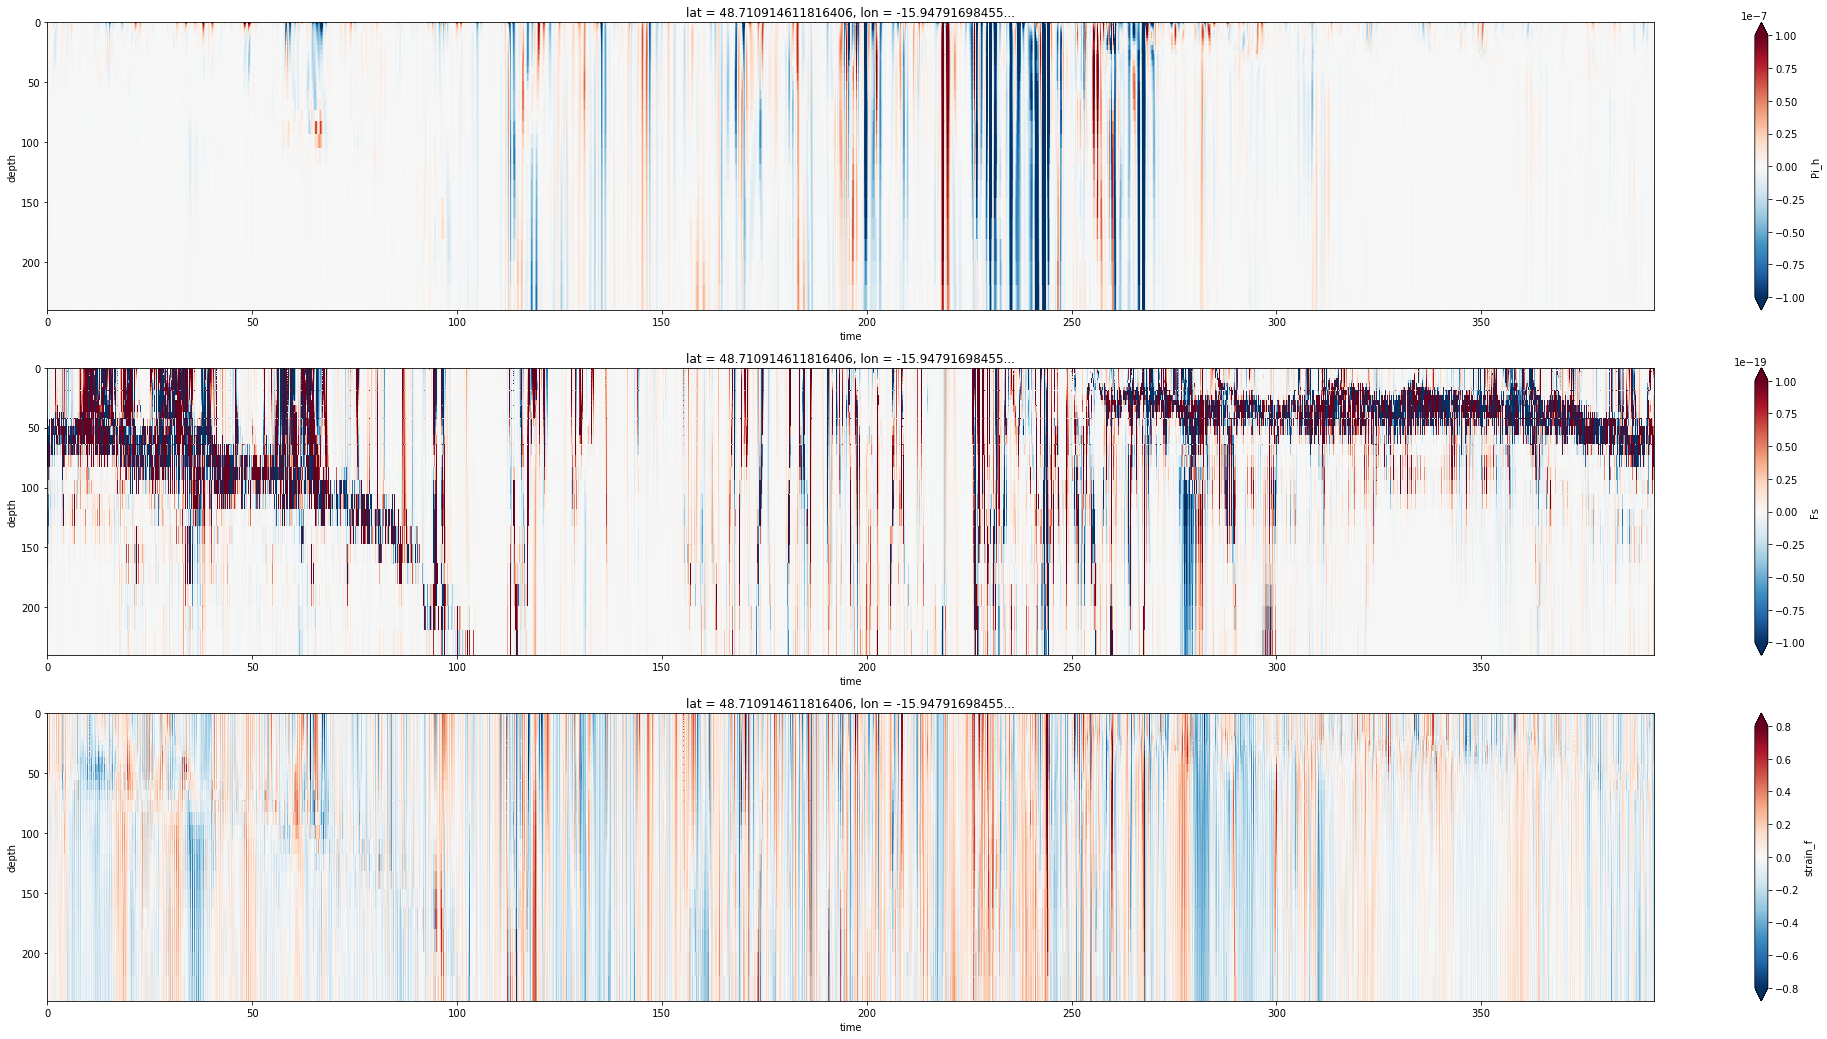

In [7]:
fig = plt.figure(figsize=(36,18))

plt.subplot(311)
ds.Pi_h.isel(lat=100,lon=100,depth=slice(0,30)).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-7,vmax=1e-7,yincrease=False)
plt.subplot(312)
ds.Fs.isel(lat=100,lon=100,depth=slice(0,30)).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-19, vmax=1e-19,yincrease=False)
plt.subplot(313)
ds.strain_f.isel(lat=100,lon=100,depth=slice(0,30)).plot(x='time', y='depth',cmap='RdBu_r', vmin=-0.8,vmax=0.8,yincrease=False)

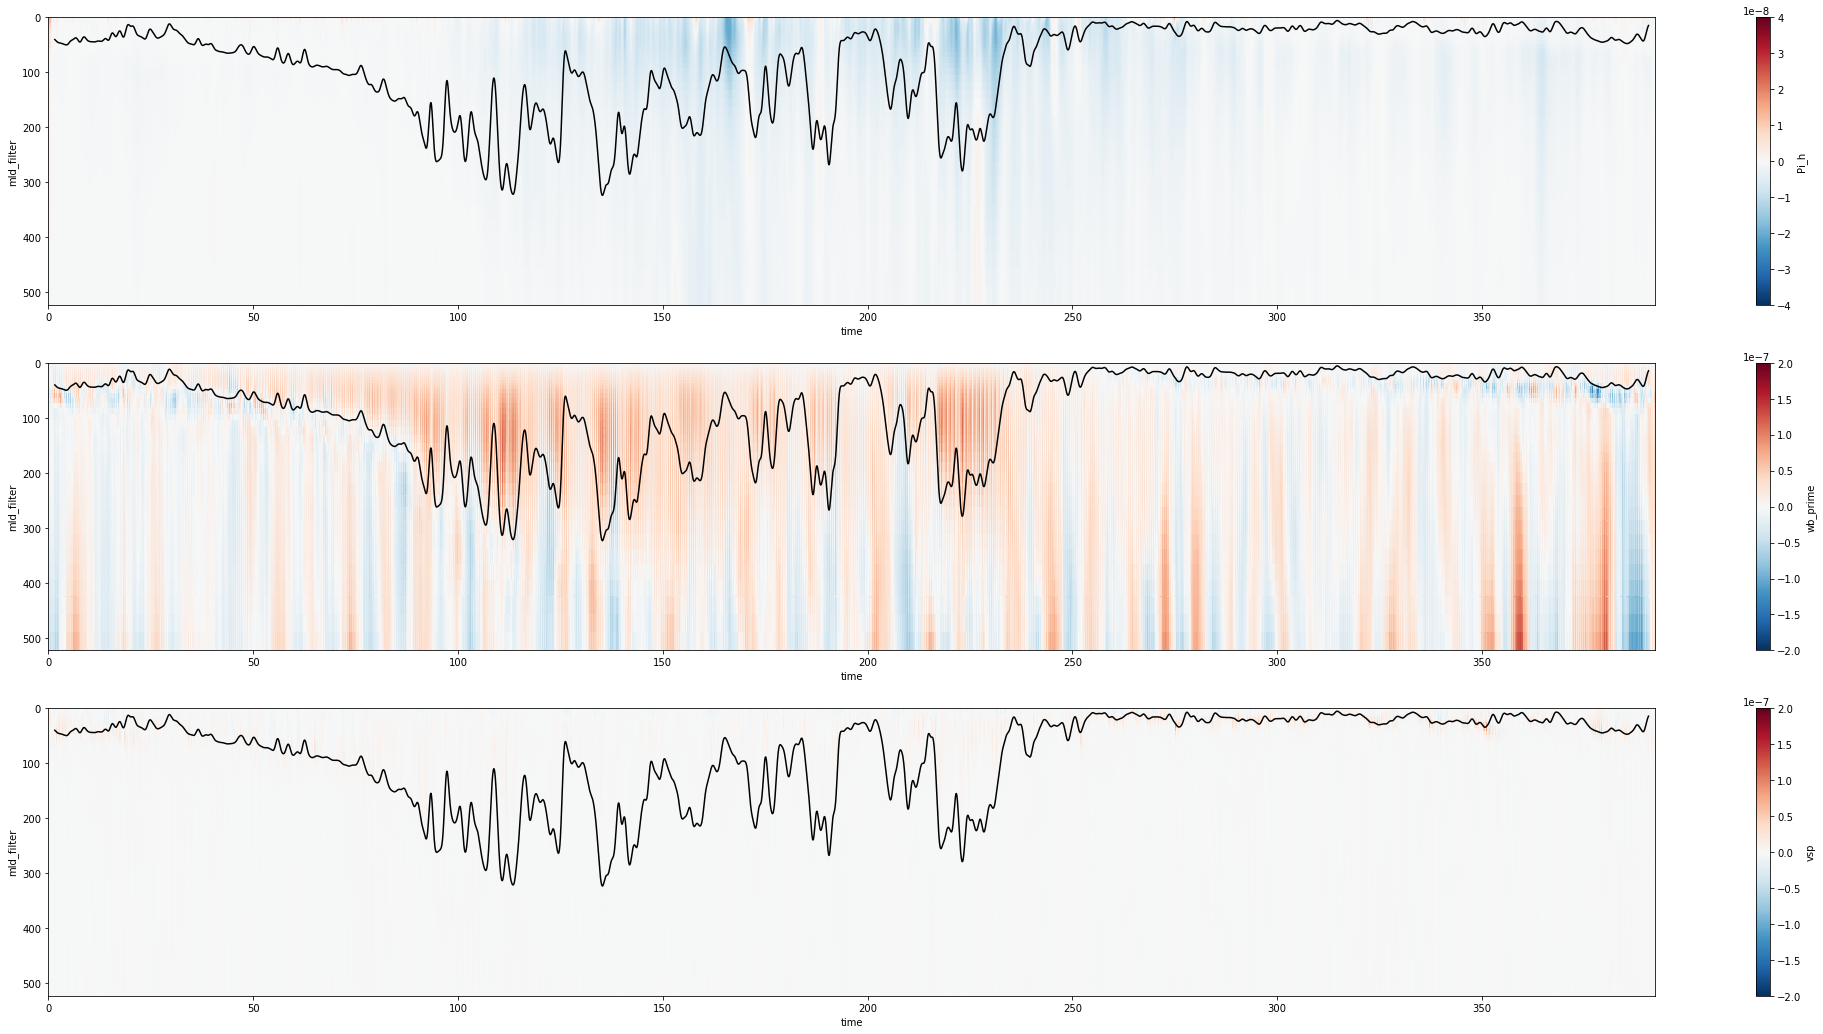

In [23]:
fig = plt.figure(figsize=(36,18))

plt.subplot(311)
ds.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1),depth=slice(0,40)).mean(['lat','lon']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-4e-8,vmax=4e-8,yincrease=False)
ds.mld_filter.mean(['lat','lon']).plot(x='time',color='black', yincrease=False)

plt.subplot(312)
ds.wb_prime.isel(depth=slice(0,40)).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-7,vmax=2e-7,yincrease=False)
ds.mld_filter.mean(['lat','lon']).plot(x='time',color='black', yincrease=False)

plt.subplot(313)
ds.vsp.isel(depth=slice(0,40)).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-7,vmax=2e-7,yincrease=False)
ds.mld_filter.mean(['lat','lon']).plot(x='time',color='black', yincrease=False)


In [25]:
cluster.scheduler.close()

<Future finished result=None>